Hoy se entrega el informe y como que nos olvidamos de tener algún estadístico/resultado cuantitativo para reportar xd (por culpa en parte de los ayudantes que no nos lo pusieron como algo imortante) pero que después de haber cursado mefe, me parece súper útil y necesario en un informee

In [3]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.special import wofz
import math


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

# funciones

In [4]:

def cargar_datos_2(n, i, ruta, a):
    
    #n número de datos tomados +1
    # i número de medición -1 (empezando a contar desde 1)
    # sufijo para cada medición distinta

    columnas = [f'{j}' for j in range(1, n)]

    # Rutas a archivos
    señales_Ch1 = os.path.join(ruta, 'Mediciones_CH1.csv')
    señales_Ch2 = os.path.join(ruta, 'Mediciones_CH2.csv')
    tiempos_Ch1 = os.path.join(ruta, 'Tiempos_CH1.csv')
    tiempos_Ch2 = os.path.join(ruta, 'Tiempos_CH2.csv')
    unidades_escalas = os.path.join(ruta, 'Unidades y escala.csv')

    # Lectura de archivos
    data_señales_Ch1 = pd.read_csv(señales_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_señales_Ch2 = pd.read_csv(señales_Ch2, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch1 = pd.read_csv(tiempos_Ch1, skiprows=3, delimiter=',', header=None, names=columnas)
    data_tiempos_Ch2 = pd.read_csv(tiempos_Ch2, skiprows=3, delimiter=',', header=None, names=columnas)
    data_unidades_escalas = pd.read_csv(unidades_escalas, delimiter=',', header=None, names=columnas)

    # Selección de columna
    col_name = str(i + 1)

    # Variables con sufijo personalizado
    globals()[f'tiempos1_{a}'] = data_tiempos_Ch1[col_name].values
    globals()[f'voltajes1_{a}'] = data_señales_Ch1[col_name].values

    globals()[f'tiempos2_{a}'] = data_tiempos_Ch2[col_name].values
    globals()[f'voltajes2_{a}'] = data_señales_Ch2[col_name].values

    escala_Ch1 = float(data_unidades_escalas[col_name].iloc[4])
    escala_Ch2 = float(data_unidades_escalas[col_name].iloc[8])

    globals()[f'error_Ch1_{a}'] = escala_Ch1 * 10 / 256
    globals()[f'error_Ch2_{a}'] = escala_Ch2 * 10 / 256


def lineal(x, m, b):
  y =  m * x + b
  return y


def graficar_6_subplots(x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, peaks): #tengo que agregar peaks para poder usarlo dentro de la función
    fig, axs = plt.subplots(3, 2, figsize=(10, 9))  # 3 filas, 2 columnas

    # Gráfico 1
    axs[0, 0].plot(x1, y1, '.', color='darkcyan', label='Canal 1')
    axs[0, 0].set_title("señal osciloscopio")
    axs[0, 0].set_xlabel("tiempo [s]")
    axs[0, 0].set_ylabel("v")

    # Gráfico 2
    axs[0, 1].plot(x2, y2, ".", color='darkslategray')
    axs[0, 1].set_title("recorte lineal")
    axs[0, 1].set_xlabel("tiempo [s]")
    axs[0, 1].set_ylabel("v")

    # Gráfico 3
    axs[1, 0].plot(x3, y3, ".", markersize=2, color='darkslategray')
    axs[1, 0].set_title("aplanado")
    axs[1, 0].set_xlabel("tiempo [s]")
    axs[1, 0].set_ylabel("Absorción [a.u.]")

    # Gráfico 4
    axs[1, 1].plot(x4, y4, ".", markersize=2, color='darkslategray')
    axs[1, 1].set_title("normalizado e invertido")
    axs[1, 1].set_xlabel("tiempo [s]")
    axs[1, 1].set_ylabel("Absorción [a.u.]")

    # Gráfico 5
    axs[2, 0].plot(x5, y5, label="señal")
    axs[2, 0].plot(x5[peaks], y5[peaks], "rx",label="picos detectados")

    axs[2, 0].set_title("picos")
    axs[2, 0].set_xlabel("tiempo [s]")
    axs[2, 0].set_ylabel("Absorción [a.u.]")
    axs[2, 0].legend()  # <-- Mostrar leyenda sólo en el quinto gráfico

    # Gráfico 6
    axs[2, 1].plot(x6, y6, ".", markersize=2, color='teal')
    axs[2, 1].set_title("reescalado")
    axs[2, 1].set_xlabel("Frecuencia relativa (Ghz)")
    axs[2, 1].set_ylabel("Absorción [a.u.]")

    plt.tight_layout()
    plt.show()



def análisis_compacto(n, i, a, ruta, A, B, C, D, h, dis, pro, graficar=True, norm=True):

        cargar_datos_2(n = n, i = i, ruta=ruta, a = 'a')

        #uso los dos extremos de la parte lineal para ajustar

        voltajes_intervalos_a = np.concatenate([voltajes1_a[A:B], voltajes1_a[C:D]])
        tiempos_intervalos_a = np.concatenate([tiempos1_a[A:B], tiempos1_a[C:D]])

        #Cuando se vea la recta, hago el ajuste:

        x_fit_a =  np.linspace(np.min(tiempos2_a), np.max(tiempos2_a), len(tiempos2_a), endpoint = True)

        param_iniciales = [0.01, 0]
        popt_0, pcov_0 = curve_fit(lineal, tiempos_intervalos_a,voltajes_intervalos_a, p0=param_iniciales, sigma = error_Ch1_a, absolute_sigma=True)
        incertidumbre_0 = np.sqrt(np.diag(pcov_0))

        tabla = pd.DataFrame({
                'Los parametros óptimos son': popt_0,
                'Los errores de los parámetros son': incertidumbre_0,
                })
        if graficar:#así oculto estas salidas
                print(tabla)


        t_espectro_a = tiempos1_a[B:C] #así ya está recortado
        espectro_a = (voltajes1_a - lineal(x_fit_a, *popt_0))[B:C] 

        #inertimos, para graficar la absorción en función del tiempo
        #Y normalizamos para que el pico de mayor amplitud valga 1
        #Además, hacemos que la señal sea toda positiva (así al comparar están todas en la misma escala vertical)
        espectro_a_inv = espectro_a * (-1)
        espectro_a_pos = espectro_a_inv - np.min(espectro_a_inv) # con el - me aseguro de si ya es toda positiva, que se baje el minimo al cero
        
        #normalizamos
        espectro_a_norm = espectro_a_pos / np.max(espectro_a_pos)

        #filtrado
        señal_suavizada_a = savgol_filter(espectro_a_norm, window_length=11, polyorder=2)
  
        #damos vuelta el espectro
        espectro_suave_a = señal_suavizada_a[::-1]


        #encuentro el primer y último pico

        peaks, props = find_peaks(
        espectro_suave_a,
        height= h,        # altura mínima del pico
        distance= dis,      # distancia mínima en puntos entre picos
        prominence= pro    # "prominencia" mínima (cuán destacado es el pico)
        )

        # obtener primer y último pico real
        x_first, x_last = t_espectro_a[peaks][0], t_espectro_a[peaks][-1]
        
        if graficar:#así oculto estas salidas
                print("Primer pico:", x_first)
                print("Último pico:", x_last)


        # reescaleo los tiempos a las frecuencias 
        # Fórmula de reescalado
        frecuencias_abs = [377.104391, 377.112040] #THz
        frecuencias_rel = [0, 7.649] #Ghz

        freq_relativas = (t_espectro_a - x_first) / (x_last - x_first) * (7.649 - 0) + 0 # le pongo el cero por si lo quiero cambiar después
        freq_absolutas = (t_espectro_a - x_first) / (x_last - x_first) * (frecuencias_abs[1] - frecuencias_abs[0]) + frecuencias_abs[0]


        if norm:
                espectro_suave_a = espectro_suave_a
        else:
                espectro_suave_a = espectro_suave_a * np.max(espectro_a_pos)




        #grafico (sólo si graficar = True)
        if graficar:
                graficar_6_subplots(tiempos1_a, voltajes1_a, tiempos_intervalos_a, voltajes_intervalos_a, t_espectro_a, espectro_a, t_espectro_a, señal_suavizada_a, t_espectro_a, espectro_suave_a, freq_relativas, espectro_suave_a, peaks = peaks)


        #creo las variables globales

        globals()[f'espectro_suave_{a}'] = espectro_suave_a
        globals()[f'f_rel_{a}'] = freq_relativas
        globals()[f'f_abs_{a}'] = freq_absolutas

        globals()[f'picos_índices_{a}'] = peaks


        #para ver el desplazamiento en función de la temperatura del láser
        #globals()[f't_raw_{a}'] = tiempos1_a
        #globals()[f'v_raw_{a}'] = voltajes1_a

        #para ver la amplitud relativa entre las señales, exporto la señal antes de normalizarla
        #señal_suavizada_a_sin_norm = savgol_filter(espectro_a_pos, window_length=11, polyorder=2) # la filtro
        #globals()[f'espectro_sin_norm_{a}'] = señal_suavizada_a_sin_norm



In [27]:
# ---------- Funciones de modelo ----------
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x-mu)/sigma)**2)

def voigt(x, A, mu, sigma_g, gamma_l):
    # normalized Voigt profile amplitude A
    z = ((x-mu) + 1j*gamma_l) / (sigma_g * np.sqrt(2))
    return A * np.real(wofz(z)) / (sigma_g * np.sqrt(2*np.pi))

def fwhm_from_sigma_gauss(sigma):
    return 2*np.sqrt(2*np.log(2)) * sigma

def fwhm_voigt(sigma_g, gamma_l):
    # approximation (Olivero & Longbothum 1977)
    f = 0.5346*2*gamma_l + np.sqrt((0.2166*(2*gamma_l))**2 + (2.35482*sigma_g)**2)
    return f

# ---------- Ajuste local (single-peak) ----------
def fit_peak_local(freq, y, center_guess, halfwidth_frac=0.01, model='gauss'):
    # select window around guess
    rng = (freq > center_guess*(1-halfwidth_frac)) & (freq < center_guess*(1+halfwidth_frac))
    x = freq[rng]
    yy = y[rng]
    if len(x) < 7:
        rng = (freq > center_guess - 0.5) & (freq < center_guess + 0.5)
        x = freq[rng]; yy = y[rng]
    # initial guesses
    A0 = yy.max() - yy.min()
    mu0 = x[np.argmax(yy)]
    sigma0 = (x.max()-x.min())/6
    if model == 'gauss':
        p0 = [A0, mu0, sigma0]
        try:
            popt, pcov = curve_fit(gaussian, x, yy, p0=p0, maxfev=5000)
            A, mu, sigma = popt
            perr = np.sqrt(np.diag(pcov))
            sigma_mu = perr[1] if perr.size>1 else np.nan
            fwhm = fwhm_from_sigma_gauss(sigma)
            return {'A':A,'mu':mu,'sigma':sigma,'fwhm':fwhm,'mu_err':sigma_mu,'cov':pcov}
        except Exception as e:
            return None
    else:
        p0 = [A0, mu0, sigma0, sigma0/2]
        try:
            popt, pcov = curve_fit(voigt, x, yy, p0=p0, maxfev=8000)
            A, mu, sigma_g, gamma_l = popt
            perr = np.sqrt(np.diag(pcov))
            sigma_mu = perr[1] if perr.size>1 else np.nan
            fwhm = fwhm_voigt(sigma_g, gamma_l)
            return {'A':A,'mu':mu,'sigma_g':sigma_g,'gamma_l':gamma_l,'fwhm':fwhm,'mu_err':sigma_mu,'cov':pcov}
        except Exception as e:
            return None

# ---------- Emparejar con líneas tabuladas ----------
def match_to_table(meas_centers, table_centers, fwhm_array, k=1.0):
    # k*FWHM criterio de match
    matched = {}
    for t in table_centers:
        # find nearest measured
        i = np.argmin(np.abs(meas_centers - t))
        delta = meas_centers[i] - t
        if abs(delta) <= k * fwhm_array[i]:
            matched[t] = {'meas':meas_centers[i],'delta':delta,'idx':i}
        else:
            matched[t] = None
    return matched

# ---------- AIC/BIC entre modelo 1 y 2 (fit sum of 1 or 2 gauss) ----------
def sum_of_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        A, mu, sigma = params[i:i+3]
        y += gaussian(x, A, mu, sigma)
    return y

def fit_1v2_gauss(freq, y, center_guess, sep_guess=0.0):
    # window selection
    window = (freq > center_guess - 2* (freq.max()-freq.min())*0.05) & (freq < center_guess + 2*(freq.max()-freq.min())*0.05)
    x = freq[window]; yy = y[window]
    # model 1
    try:
        p01 = [yy.max()-yy.min(), center_guess, (x.max()-x.min())/6]
        popt1, pcov1 = curve_fit(gaussian, x, yy, p0=p01, maxfev=5000)
        resid1 = yy - gaussian(x, *popt1)
        sse1 = np.sum(resid1**2)
        n = len(yy); k1 = len(popt1)
        aic1 = n * np.log(sse1/n) + 2*k1
    except:
        aic1 = np.inf; popt1=None; sse1=np.inf
    # model 2
    try:
        p02 = [ (yy.max()-yy.min())*0.6, center_guess - sep_guess/2, (x.max()-x.min())/10,
                (yy.max()-yy.min())*0.4, center_guess + sep_guess/2, (x.max()-x.min())/10 ]
        popt2, pcov2 = curve_fit(sum_of_gauss, x, yy, p0=p02, maxfev=8000)
        resid2 = yy - sum_of_gauss(x, *popt2)
        sse2 = np.sum(resid2**2)
        k2 = len(popt2)
        aic2 = n * np.log(sse2/n) + 2*k2
    except:
        aic2 = np.inf; popt2=None; sse2=np.inf
    return {'aic1':aic1,'aic2':aic2,'popt1':popt1,'popt2':popt2,'sse1':sse1,'sse2':sse2}


# análisis

   Los parametros óptimos son  Los errores de los parámetros son
0                   72.728123                           0.074081
1                  -13.503824                           0.013921
Primer pico: 0.187947
Último pico: 0.188708


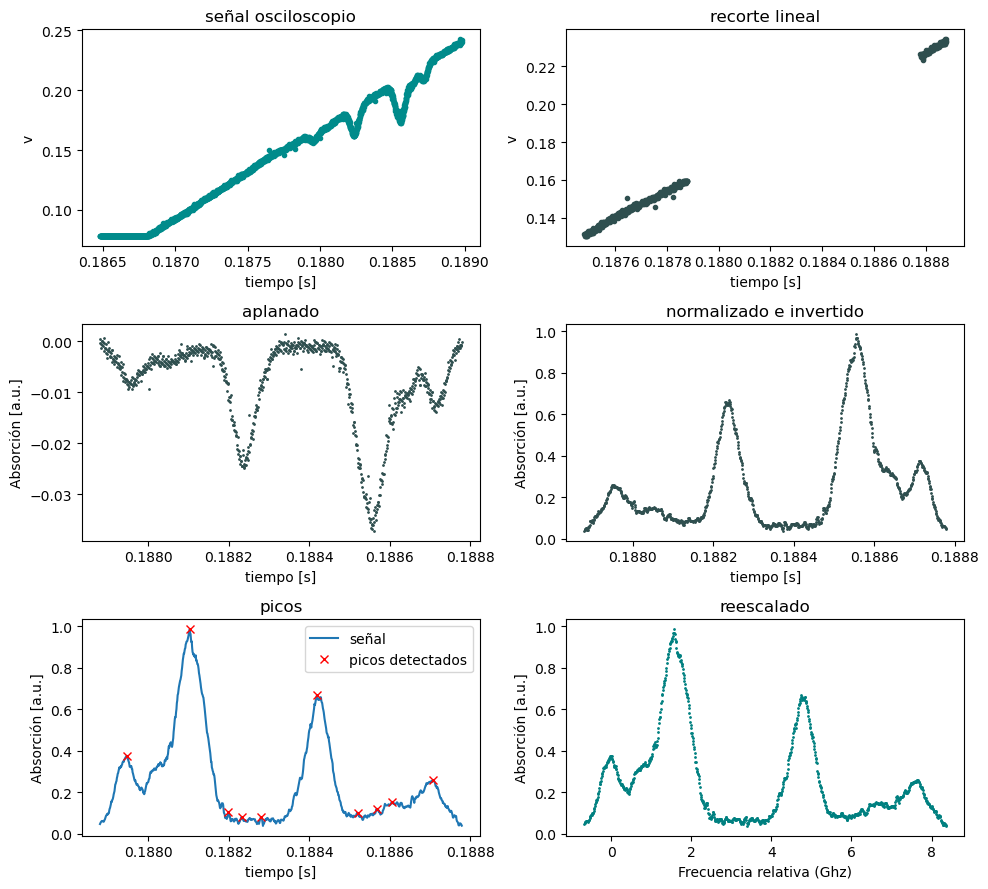

[ 67 223 319 352 401 539 640 689 726 828]


In [12]:
#Ajuste local de picos individuales (Gaussiana/Voigt) → obtener centro ν, FWHM y σ_ν.

análisis_compacto(n=2, i=0, a = 'a', ruta='/Users/Mauri/Desktop/Labo 5/Espectroscopía láser/Med1', A =1000
                  , B = 1400, C = 2300, D = 2400, h = 0.05, dis = 30, pro = 0.02, graficar=True,  norm=True)

print(picos_índices_a)


In [30]:
indices_picos = [67, 548, 238, 150, 726, 539, 828, 223]

# frecuencias picos en Herzios
# lo voy a hacer con el eje ajustado en base al primero y al último porque no llego si no
#paso de THz a Hz
f_abs_Hz = f_abs_a * 1e+12

freq = f_abs_Hz
absorb = espectro_suave_a
p = f_abs_Hz[0]

fit_peak_local(freq, absorb, p, halfwidth_frac=0.005, model='voigt')

{'A': 0.9487173172654122,
 'mu': 377105958994743.8,
 'sigma_g': 1506012045.5416667,
 'gamma_l': 753006022.7708334,
 'fwhm': 4366472018.884339,
 'mu_err': 3.191412790374939e+17,
 'cov': array([[ 6.37247023e+14, -1.75215219e+23, -2.21987118e+23,
         -1.21184624e+23],
        [-1.75215219e+23,  1.01851156e+35, -7.70059906e+32,
          1.18342323e+32],
        [-2.21987118e+23, -7.70059906e+32,  9.94681850e+33,
         -4.74993436e+33],
        [-1.21184624e+23,  1.18342323e+32, -4.74993436e+33,
          4.39488237e+33]])}

In [ ]:
# bueno no hay tiempo

# Análisis cualitativo



Idea central (rápida)

Usa emparejado “nearest neighbor” entre líneas tabuladas y picos medidos.

Si dos líneas tabuladas quedan asignadas al mismo pico medido, consideralas no resueltas → su separación es una cota superior para la resolución.

Si dos líneas tabuladas quedan asignadas a dos picos distintos, consideralas resueltas → su separación es una cota inferior para la resolución.

A partir de la distribución de separaciones de pares resueltos/no resueltos construís un intervalo y un número resumen (por ejemplo, la mediana o el percentil 95) para la resolución efectiva.

In [6]:
análisis_compacto(n=2, i=0, a = 'a', ruta='/Users/Mauri/Desktop/Labo 5/Espectroscopía láser/Med1', A =1000
                  , B = 1400, C = 2300, D = 2400, h = 0.05, dis = 30, pro = 0.02, graficar=False,  norm=True)


In [11]:
freqs =np.array([0, 0.814, 1.518, 1.883, 4.556, 4.916, 6.835, 7.649])

freqs_abs_tab = freqs + 377.104391 #
 
freqs_abs_tab_Hz = freqs_abs_tab * 1e12

print(freqs_abs_tab_Hz)

[3.77104391e+14 3.77918391e+14 3.78622391e+14 3.78987391e+14
 3.81660391e+14 3.82020391e+14 3.83939391e+14 3.84753391e+14]


In [15]:
f_abs_Hz = f_abs_a * 1e+12
freq = f_abs_Hz

indices_picos = [67, 548, 238, 150, 726, 539, 828, 223]

frecuencias_picos = []#Hz

frecuencias_tabuladas = [3.77104391e+14, 3.77918391e+14, 3.78622391e+14, 3.78987391e+14,
3.81660391e+14, 3.82020391e+14, 3.83939391e+14, 3.84753391e+14]#Hz

for i in range(len(indices_picos)):
    frecuencias_picos.append(freq[i])

#picos medidos
meas_freqs = np.array(frecuencias_picos)

# tus líneas tabuladas (Hz)
table_freqs = np.array(frecuencias_tabuladas)

print(table_freqs)
print(meas_freqs)



[3.77104391e+14 3.77918391e+14 3.78622391e+14 3.78987391e+14
 3.81660391e+14 3.82020391e+14 3.83939391e+14 3.84753391e+14]
[3.77103718e+14 3.77103728e+14 3.77103738e+14 3.77103748e+14
 3.77103758e+14 3.77103768e+14 3.77103778e+14 3.77103788e+14]


In [14]:
# --- Emparejar cada línea tabulada con el pico medido más cercano ---
idx = np.argmin(np.abs(table_freqs[:, None] - meas_freqs[None, :]), axis=1)
matched_meas = meas_freqs[idx]
deltas = matched_meas - table_freqs  # diferencias Hz

# --- Calcular sesgo y dispersión (opcional) ---
bias = deltas.mean()
rmse = np.sqrt(np.mean(deltas**2))

# --- Ver si dos líneas tabuladas caen en el mismo pico (no resueltas) ---
order = np.argsort(table_freqs)
tab_sorted = table_freqs[order]
idx_sorted = idx[order]

separaciones = np.diff(tab_sorted)
resueltas = idx_sorted[:-1] != idx_sorted[1:]

sep_resueltas = separaciones[resueltas]
sep_no_resueltas = separaciones[~resueltas]

# --- Estimar resolución efectiva ---
if len(sep_no_resueltas) > 0:
    resol_mediana = np.median(sep_no_resueltas)
else:
    resol_mediana = np.nan

print("Sesgo promedio (Hz):", bias)
print("RMSE (Hz):", rmse)
print("Pares resueltos:", np.sum(resueltas))
print("Pares no resueltos:", np.sum(~resueltas))
print("Resolución efectiva (mediana no resueltos):", resol_mediana, "Hz")
print("≈", resol_mediana / 1e6, "MHz")

Sesgo promedio (Hz): -3521978074901.4375
RMSE (Hz): 4425709100750.007
Pares resueltos: 0
Pares no resueltos: 7
Resolución efectiva (mediana no resueltos): 814000000000.0 Hz
≈ 814000.0 MHz


nah cualquiera, voy a centrarme en que sea consistente y listo